# Cryptocurrency Trading Strategy with Machine Learning

In this notebook, we will develop a trading strategy that combines several technical indicators with a Long Short-Term Memory (LSTM) model to predict asset price movements and generate trading signals. We'll use data from Binance and explore how each component influences our predictions and trading returns.

## Goals
1. Retrieve historical price data from Binance.
2. Apply independent trading strategies (RSI reversion, EWMA cross, Bollinger Band breakout).
3. Progressively add these signals to an LSTM model and observe how predictions evolve.
4. Generate a return series from the final model and compare it to a buy-and-hold benchmark.


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import quantstats as qs
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# Add the root directory to the Python path
sys.path.append(os.getcwd())

from binance_provider import get_historical_data
from strategy import RunOptions, EWMACrossFactor, MACDDifferenceFactor, BollingerBandFactor, RsiFactor
from model import train_conv_lstm

# Step 1: Retrieving Data from Binance

Using the Binance API, we’ll retrieve historical price data for our selected cryptocurrency pair (e.g., BTC/USDT). This data will serve as the foundation for our technical indicators and model inputs.

- **Objective**: Collect data on price, volume, and other trading metrics.
- **Data**: We’ll be working primarily with OHLCV (Open, High, Low, Close, Volume) data.

### Code Explanation
- **API Call**: We connect to Binance’s API to fetch historical data.
- **Data Cleaning**: We check for any missing values and format our data for analysis.


In [2]:
symbol = 'DOGEUSDT'
timeframe = '1h'
eth_data = get_historical_data(symbol, timeframe, datetime(2018, 1, 1), datetime.now()) 
eth_data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,,,
2020-07-10 10:00:00,2020-07-10 10:00:00,0.003989,0.003989,0.003340,0.003735,600365408.0,2020-07-10 10:59:59.999,2.258832e+06,22244,286098571.0,1.078366e+06
2020-07-10 11:00:00,2020-07-10 11:00:00,0.003736,0.003915,0.003630,0.003891,528377228.0,2020-07-10 11:59:59.999,1.991775e+06,13082,297038868.0,1.123265e+06
2020-07-10 12:00:00,2020-07-10 12:00:00,0.003891,0.003900,0.003687,0.003739,453535872.0,2020-07-10 12:59:59.999,1.715900e+06,7509,206649956.0,7.817386e+05
2020-07-10 13:00:00,2020-07-10 13:00:00,0.003739,0.003838,0.003690,0.003743,328382368.0,2020-07-10 13:59:59.999,1.236025e+06,10201,173539256.0,6.539173e+05
2020-07-10 14:00:00,2020-07-10 14:00:00,0.003743,0.003810,0.003704,0.003733,252982832.0,2020-07-10 14:59:59.999,9.506146e+05,9000,134622336.0,5.067844e+05
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-29 08:00:00,2024-10-29 08:00:00,0.164720,0.165540,0.164300,0.165150,247182928.0,2024-10-29 08:59:59.999,4.079615e+07,71148,119519764.0,1.972993e+07
2024-10-29 09:00:00,2024-10-29 09:00:00,0.165160,0.165530,0.163890,0.164550,264473015.0,2024-10-29 09:59:59.999,4.356196e+07,78808,136139949.0,2.242587e+07
2024-10-29 10:00:00,2024-10-29 10:00:00,0.164550,0.166040,0.163540,0.165440,352506015.0,2024-10-29 10:59:59.999,5.811434e+07,101178,182004711.0,3.000458e+07


### Step 2: Calculating Technical Indicators and Generating Signals

In this section, we calculate several technical indicators for Ethereum (ETH) based on the historical price data retrieved. Each indicator produces a **signal** that will be used as an input feature for our model.

#### Technical Indicators Used:
1. **Exponential Moving Average (EMA) Cross**:  
   - **Parameters**: `slow_window` of 12 hours, `fast_window` of 26 hours.
   - **Purpose**: Identifies crossovers between fast and slow EMAs, signaling potential trend changes.

2. **MACD (Moving Average Convergence Divergence)**:
   - **Parameters**: `slow_window` (12), `fast_window` (26), `signal_window` (9).
   - **Purpose**: Measures the difference between fast and slow EMAs. A positive signal suggests a potential upward trend, while a negative signal indicates a possible downward trend.
   
3. **Bollinger Bands**:
   - **Parameters**: `window` of 20 periods, `low_pos` (set to 0 here).
   - **Purpose**: Assesses volatility by observing price relative to upper and lower bands. A signal is generated when prices deviate significantly from the mean.

4. **RSI (Relative Strength Index)**:
   - **Parameters**: `window` of 14, `overbought` level at 50, `oversold` level at 47.
   - **Purpose**: Detects overbought (potential sell signal) or oversold (potential buy signal) conditions based on recent price momentum.

#### Signal Generation
- Each indicator’s `get_signal()` function is applied to Ethereum’s hourly closing prices. The output is stored in the `signal_df` DataFrame, adding the following columns:
   - `ma_signal` for EMA cross signals.
   - `macd_signal` for MACD-based signals.
   - `bband_signal` for Bollinger Band deviations.
   - `rsi_signal` for RSI-based overbought/oversold conditions.

This DataFrame will be used to feed signals into our LSTM model in later steps.



In [3]:
time_scaler = 24 if timeframe == '1h' else 1 # This works only for 1h and 1d timeframes
ma_cross = EWMACrossFactor(slow_window= 12 * time_scaler,fast_window=  26 * time_scaler)
macd = MACDDifferenceFactor(slow_window= 12 * time_scaler, fast_window= 26 * time_scaler, signal_window= 9* time_scaler, short_signal=0, is_binary=True)
bollinger_band = BollingerBandFactor(window= 20 * time_scaler, low_pos=0)
rsi = RsiFactor(14 * time_scaler, ovr_bought_lvl=50, ovr_sold_lvl=47)


signal_df = eth_data[['close']].copy()
signal_df['ma_signal'] = await ma_cross.get_signal(signal_df['close'])
signal_df['macd_signal'] = await macd.get_signal(signal_df['close'])
signal_df['bband_signal']  = await bollinger_band.get_signal(signal_df['close'])
signal_df['rsi_signal'] = await rsi.get_signal(signal_df['close'], )
signal_df.tail(10)


c:\code\crypto\ml-lecture\strategy.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)


,close,ma_signal,macd_signal,bband_signal,rsi_signal
open_time,,,,,
2024-10-29 03:00:00,0.16719,0,0,0,1
2024-10-29 04:00:00,0.16539,0,0,0,1
2024-10-29 05:00:00,0.16493,0,0,0,1
2024-10-29 06:00:00,0.16478,0,0,0,1
2024-10-29 07:00:00,0.16472,0,0,0,1
2024-10-29 08:00:00,0.16515,0,0,0,1
2024-10-29 09:00:00,0.16455,0,0,0,1
2024-10-29 10:00:00,0.16544,0,0,0,1
2024-10-29 11:00:00,0.16658,0,0,0,1


### Step 3: Visualizing Close Price and Trading Signals

In this section, we plot the assets closing price alongside the signals generated by each technical indicator to visually interpret the trading signals.

#### Plot Description
- **Close Price (Blue Line)**: Represents the hourly closing prices of Ethereum, showing overall price trends.
- **Trading Signals**:
   - **MA Signal (Red Dashed Line)**: Shows signals based on EMA crossovers.
   - **MACD Signal (Green Dashed Line)**: Represents signals generated by the MACD indicator.
   - **Bollinger Band Signal (Purple Dashed Line)**: Indicates volatility signals when the price moves significantly away from the mean.
   - **RSI Signal (Orange Dashed Line)**: Displays overbought or oversold reversion conditions as detected by the RSI.

#### Interpreting the Signals
- **Signal Values**: Each signal moves between 0 (no position) and 1 (fully long), representing a simplified approach where:
   - `0` = Hold or no position.
   - `1` = Long position, suggesting a buy signal.
- **Purpose**: This plot helps us visualize where each indicator suggests taking a position. By observing these signals over time, we can understand how each indicator responds to price changes and where signals align or diverge.

This visualization serves as a reference to see the effect of each technical indicator on trading decisions before we feed these signals into our LSTM model.



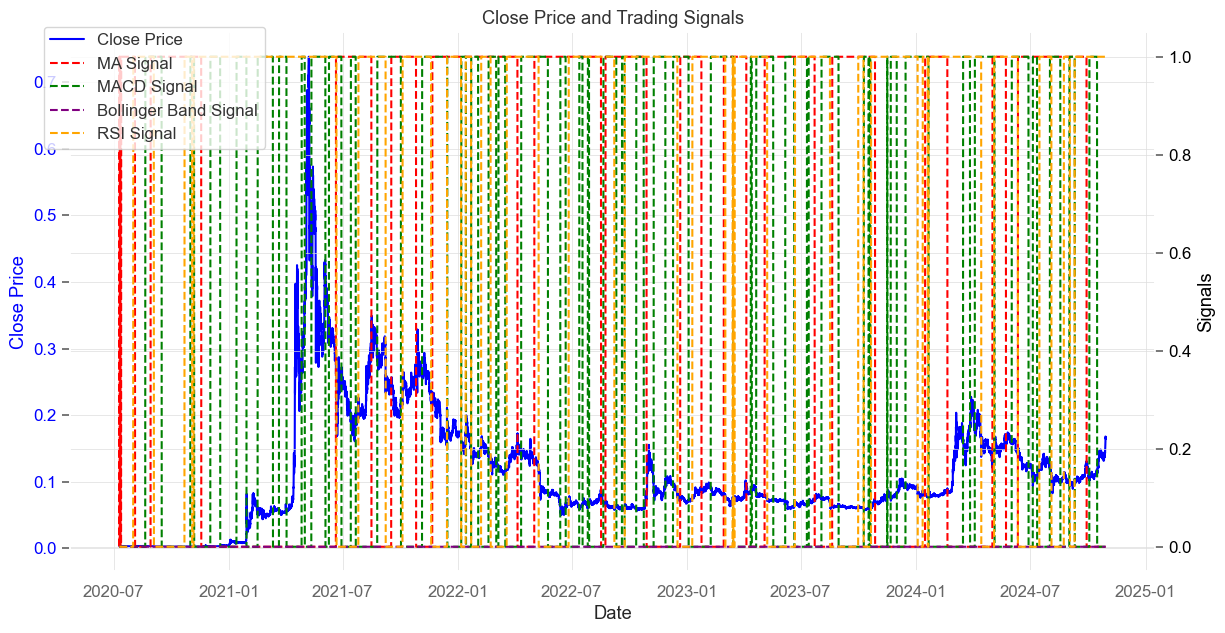

,close,ma_signal,macd_signal,bband_signal,rsi_signal,returns,returns_direction,volatility,volume
open_time,,,,,,,,,
2020-07-10 10:00:00,0.003735,0,0,0,0,NaN,0,NaN,600365408.0
2020-07-10 11:00:00,0.003891,0,0,0,0,0.040918,1,NaN,528377228.0
2020-07-10 12:00:00,0.003739,0,0,0,0,-0.039848,0,NaN,453535872.0
2020-07-10 13:00:00,0.003743,1,0,0,0,0.001069,1,NaN,328382368.0
2020-07-10 14:00:00,0.003733,1,0,0,0,-0.002675,0,NaN,252982832.0
...,...,...,...,...,...,...,...,...,...
2024-10-29 08:00:00,0.165150,0,0,0,1,0.002607,1,0.015805,247182928.0
2024-10-29 09:00:00,0.164550,0,0,0,1,-0.003640,0,0.015766,264473015.0
2024-10-29 10:00:00,0.165440,0,0,0,1,0.005394,1,0.015128,352506015.0


In [4]:


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()
ax2.plot(signal_df.index, signal_df['ma_signal'], color='red', label='MA Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['macd_signal'], color='green', label='MACD Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['bband_signal'], color='purple', label='Bollinger Band Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_signal'], color='orange', label='RSI Signal', linestyle='--')
ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and Trading Signals')

# Calculate the log returns of the close price
signal_df['returns'] = np.log(signal_df['close'] / signal_df['close'].shift(1))
# Calculate if the returns went up (1) or down (-1)
signal_df['returns_direction'] = np.where(signal_df['returns'] > 0, 1, 0)

signal_df['volatility'] = signal_df['returns'].rolling(window=20).std()
signal_df['volume'] = eth_data['volume']

# Display the first few rows to verify
plt.show()
signal_df

### Step 4: Preparing Data for the LSTM Model

In this step, we prepare our dataset for training the LSTM model by normalizing features, creating sequences, and splitting the data into training and testing sets.

#### Data Preparation Steps
1. **Feature Selection**:
   - We define key features for model training: `['close', 'ma_signal', 'macd_signal', 'bband_signal', 'rsi_signal', 'volatility', 'volume']`.
   - **Target**: The target variable, `returns_direction`, represents the future direction of returns (up or down).

2. **Normalization**:
   - **Purpose**: To standardize feature values between 0 and 1, we use MinMaxScaler. This normalization improves model stability and ensures faster convergence during training.
   
3. **Sequence Creation**:
   - **Window Size**: A window size of 5 days (or 120 hours for hourly data) is defined. This sets the time frame for each sequence, allowing the model to learn from recent data points.
   - **Function `create_sequences`**: We generate sequences by grouping data points within the defined window, creating arrays `X` (features) and `y` (target) for model training.

4. **Training and Testing Split**:
   - We split the sequences into training and testing datasets, with 80% of the data used for training (`X_train`, `y_train`) and 20% for testing (`X_test`, `y_test`).
   - **Purpose**: This split allows us to validate the model’s performance on unseen data.

With this data structure, our LSTM model will learn to predict the future direction of returns based on historical price data and signals.


In [5]:
data = signal_df.copy()

# Drop rows with NaN values
data.dropna(inplace=True)

# Data Preparation
features = ['close', 'ma_signal', 'macd_signal', 'bband_signal', 'rsi_signal', 'volatility', 'volume']
target = 'returns_direction'

# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

### Step 5: Building, Training, and Evaluating the Conv1D-LSTM Model

In this section, we define a model that combines **1D Convolutional Layers** and **LSTM** layers to analyze sequential data and classify the direction of returns. The model is built to handle potential class imbalance and is optimized for binary classification (up or down).

#### Model Components
1. **Conv1D Layer**: Applies a 1-dimensional convolution over the input data to detect local patterns (such as trends) within the window size.
2. **Batch Normalization**: Normalizes activations, improving model stability and speed.
3. **Dropout Layers**: Reduces overfitting by randomly setting a fraction of input units to zero during training.
4. **LSTM Layer**: Captures temporal dependencies in the data, crucial for predicting sequential patterns in financial time series.
5. **Dense Output Layer**: Uses sigmoid activation for binary classification, predicting whether returns will go up (1) or stay neutral/down (0).

#### Training the Model
- **Class Weights**: To address class imbalance, class weights are calculated based on the `y_train` labels and passed into `model.fit()`. This helps balance the influence of each class during training.
- **Compile and Fit**: The model is compiled with:
  - `Adam` optimizer for efficient gradient descent.
  - `binary_crossentropy` loss for binary classification tasks.
  - `accuracy` as a performance metric to track training and validation accuracy.

#### Interpreting the Training Output
The model output displays the following for each epoch:
- **Epoch**: The training cycle, where the model adjusts weights to minimize loss. We’ve set it to run for 10 epochs.
- **Accuracy and Loss**: For both training and validation data:
  - **Loss**: Measures how well the model’s predictions align with actual values. A lower loss indicates a better fit.
  - **Accuracy**: The percentage of correct predictions. Here’s how to interpret:
    - **Training Accuracy**: Measures how well the model fits the training data.
    - **Validation Accuracy**: Indicates how well the model generalizes to unseen data (the testing set in this case).
  - **Example Interpretation**:  
    - Epoch 1: Training accuracy starts at 50%, with a high loss of around 0.704, suggesting the model has a lot to learn.
    - Subsequent Epochs: As the model trains, loss decreases slightly, and accuracy may fluctuate. By the last epoch, if accuracy remains around 50%, it might indicate a need for further tuning or more data.

#### Model Evaluation
- **Evaluation Results**: After training, we evaluate the model on the test set. This gives a final test loss and accuracy, which help gauge how well the model might perform on new data.
- **General Goal**: We aim for low test loss and high accuracy, indicating strong generalization. Here, consistent accuracy near 50% suggests the model might be struggling, possibly due to class imbalance or data complexity.

With these insights, students can understand how to track and interpret training results, recognizing signs of overfitting, underfitting, and the need for model tuning.


In [6]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')

c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.4997 - loss: 0.7034 - val_accuracy: 0.5127 - val_loss: 0.6932
Epoch 2/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.5020 - loss: 0.6959 - val_accuracy: 0.5068 - val_loss: 0.6932
Epoch 3/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5017 - loss: 0.6944 - val_accuracy: 0.5042 - val_loss: 0.6931
Epoch 4/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5051 - loss: 0.6935 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 5/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5034 - loss: 0.6933 - val_accuracy: 0.5083 - val_loss: 0.6930
Epoch 6/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.5046 - loss: 0.6931 - val_accuracy: 0.4993 - val_loss: 0.6938
Epoch 7/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.4954 - val_loss: 0.6936
Epoch 8/10
940/940 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5108 - loss: 0.6930 - 

### Step 6: Generating and Visualizing Multiple RSI Signals

In this block, we calculate and plot several RSI signals with varying timeframes and overbought/oversold levels to capture different market perspectives.

#### RSI Signal Variants
- **RSI 2W**: 2-week RSI with thresholds at 50 (overbought) and 47 (oversold).
- **RSI 1W**: 1-week RSI with thresholds at 60 and 45.
- **RSI 0.5D**: Half-day RSI with thresholds at 80 and 40.
- **RSI 1D**: 1-day RSI with thresholds at 80 and 40.
- **RSI 4D**: 4-day RSI with thresholds at 70 and 40.

These RSI variants provide diverse signals, allowing us to observe short- and long-term overbought or oversold conditions in Ethereum’s price.

#### Plot Description
- **Close Price** (Blue Line): Shows the closing price over time.
- **RSI Signals**: Each RSI signal is plotted as a separate line on the secondary axis, indicating whether the market is signaling an overbought or oversold condition based on each timeframe.

This visualization helps us compare RSI signals of varying timeframes and thresholds, revealing how different configurations may lead to varying buy/sell signals.


c:\code\crypto\ml-lecture\strategy.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)
c:\code\crypto\ml-lecture\strategy.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)
c:\code\crypto\ml-lecture\strategy.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecat

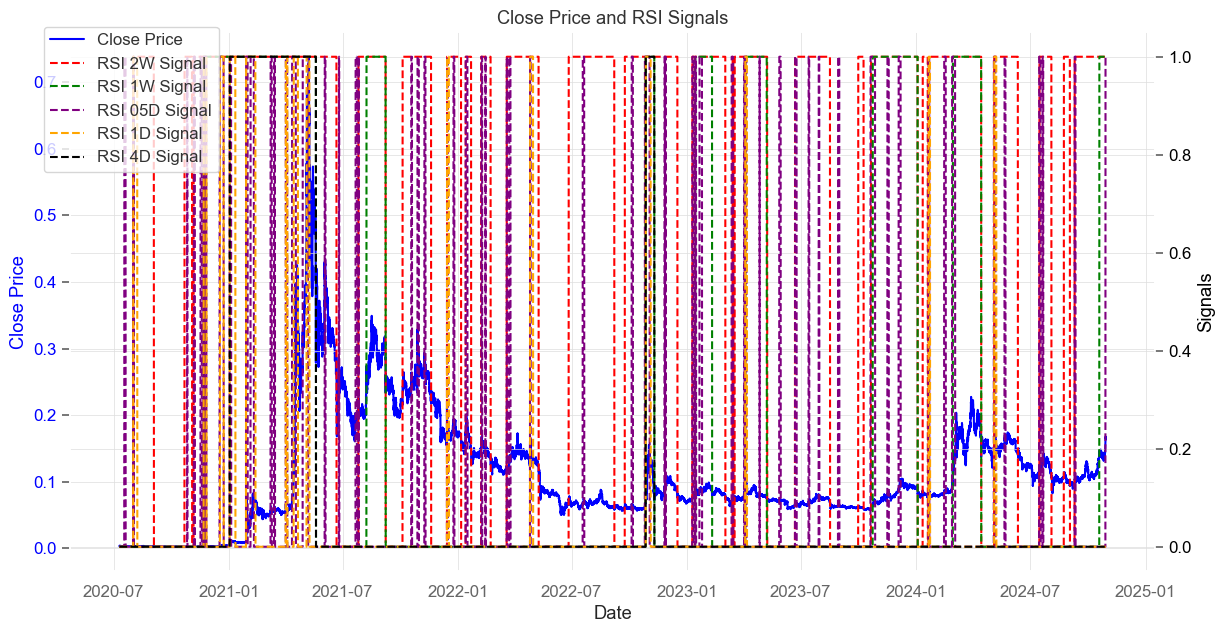

In [7]:
rsi_2w = RsiFactor(14 * time_scaler, ovr_bought_lvl=50, ovr_sold_lvl=47)
rsi_1w = RsiFactor(7 * time_scaler, ovr_bought_lvl=60, ovr_sold_lvl=45)
rsi_05d = RsiFactor(14 , ovr_bought_lvl=80, ovr_sold_lvl=40)
rsi_1d = RsiFactor(24 , ovr_bought_lvl=80, ovr_sold_lvl=40)
rsi_4d = RsiFactor(96 , ovr_bought_lvl=70, ovr_sold_lvl=40)



# signal_df = eth_data[['close']].copy()
signal_df['rsi_2w_signal'] = await rsi_2w.get_signal(signal_df['close'])
signal_df['rsi_1w_signal'] = await rsi_1w.get_signal(signal_df['close'])
signal_df['rsi_05d_signal'] = await rsi_05d.get_signal(signal_df['close'])
signal_df['rsi_1d_signal'] = await rsi_1d.get_signal(signal_df['close'])
signal_df['rsi_4d_signal'] = await rsi_4d.get_signal(signal_df['close'])


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()
ax2.plot(signal_df.index, signal_df['rsi_2w_signal'], color='red', label='RSI 2W Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_1w_signal'], color='green', label='RSI 1W Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_05d_signal'], color='purple', label='RSI 05D Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_1d_signal'], color='orange', label='RSI 1D Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_4d_signal'], color='black', label='RSI 4D Signal', linestyle='--')
ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and RSI Signals')

plt.show()

### Step 7: Re-Training the Model with Additional RSI Signals

In this section, we incorporate the new RSI signals into our feature set to see if adding more diverse data points enhances the model's predictive performance.

#### Objectives
- **Expanded Features**: Our features now include multiple RSI signals generated from different timeframes, allowing the model to capture more nuanced market conditions.
- **Goal**: Evaluate if the model’s accuracy improves with the addition of new RSI-based signals, as they provide more comprehensive information on price momentum.

#### Data Preparation
1. **Feature and Target Selection**: We set `features` to include all RSI signals and other indicators.
2. **Handling NaN and Infinity Values**: Missing or infinite values are handled by replacing them with column averages to ensure data consistency.
3. **Normalization**: We apply MinMaxScaler to normalize features between 0 and 1, a common practice for neural network stability.

#### Training Results
- **Evaluation Metrics**: We evaluate the model on the test set and display the final test loss and accuracy. Comparing this result to the previous model will help us determine if adding additional RSI signals improved predictive power.

This process allows us to examine how adding more granular signals impacts model performance, guiding future improvements to our trading model.


In [ ]:
target = 'returns_direction'
rsi_features = [x for x in  signal_df.columns if x != target]
features = rsi_features
# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24
data = signal_df.copy()

# Handle NaN and infinity values in the data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Flatten y_train and y_test
y_train = y_train.flatten()
y_test = y_test.flatten()

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')


c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
941/941 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5027 - loss: 0.7103 - val_accuracy: 0.4989 - val_loss: 0.6946
Epoch 2/30
941/941 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5104 - loss: 0.6981 - val_accuracy: 0.5059 - val_loss: 0.6947
Epoch 3/30
941/941 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5069 - loss: 0.6990 - val_accuracy: 0.5075 - val_loss: 0.6934
Epoch 4/30
941/941 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.4919 - loss: 0.6997 - val_accuracy: 0.4969 - val_loss: 0.6943
Epoch 5/30
941/941 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.5038 - loss: 0.6979 - val_accuracy: 0.4994 - val_loss: 0.6938
Epoch 6/30
227/941 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5031 - loss: 0.6981

### Step 8: Generating and Visualizing Moving Average Cross Signals

In this section, we calculate several Moving Average (MA) cross signals, each with different slow and fast windows, to capture various trend durations. These signals are based on the concept of **Exponential Weighted Moving Average (EWMA)** crossovers, which help detect shifts in price direction.

#### Moving Average Cross Signals
- **MA GC (Golden Cross)**: Long-term signal with slow (200) and fast (50) windows, often used to identify major trend reversals.
- **MA Short Term**: Short-term signal using 20 (slow) and 5 (fast) windows, designed to capture quick market changes.
- **MA Mid Term**: Medium-term signal with 50 (slow) and 20 (fast) windows, balancing responsiveness and trend stability.
- **MA Quick React**: Quick-reacting crossover with 15 (slow) and 5 (fast) windows for ultra-short-term trends.
- **MA Fib**: Uses Fibonacci numbers (34, 13) as slow and fast windows to explore potential alternative timing for crossovers.

#### Plot Description
- **Close Price (Blue Line)**: Plots Ethereum’s closing price for context.
- **MA Signals**: Various MA cross signals are plotted on the secondary y-axis:
   - `MA GC Signal` (Red): Indicates long-term trend shifts.
   - `MA Short Term Signal` (Green): Reflects short-term market changes.
   - `MA Mid Term Signal` (Purple): Captures mid-range trends.
   - `MA Fib Signal` (Yellow): Based on Fibonacci windows, providing an alternative perspective on market timing.

Each MA signal line represents either a `0` (no position) or `1` (long position) based on whether the fast moving average is above the slow moving average, signaling an uptrend.

#### Purpose
This visualization allows us to compare different MA cross signals, each targeting a unique timeframe. The goal is to observe if these variations offer more refined trading signals that could improve the model's predictive power when added as features.



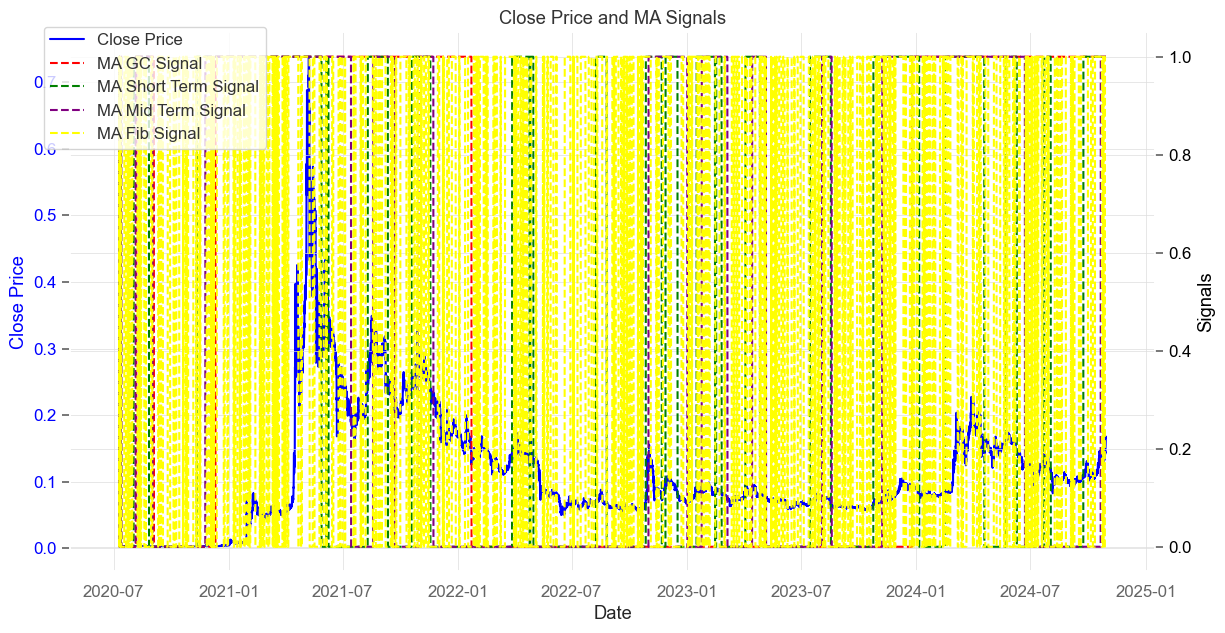

,close,ma_signal,macd_signal,bband_signal,rsi_signal,returns,returns_direction,volatility,volume,rsi_2w_signal,rsi_1w_signal,rsi_05d_signal,rsi_1d_signal,rsi_4d_signal,ma_gc_signal,ma_short_term_signal,ma_mid_term_signal,ma_quick_react_signal
open_time,,,,,,,,,,,,,,,,,,
2024-10-28 16:00:00,0.14973,0,0,0,1,0.012230,1,0.012145,4.945624e+08,1,1,0,0,0,1,1,1,1
2024-10-28 17:00:00,0.15038,0,0,0,1,0.004332,1,0.012147,6.964922e+08,1,1,0,0,0,1,1,1,1
2024-10-28 18:00:00,0.15307,0,0,0,1,0.017730,1,0.012540,9.461266e+08,1,1,0,0,0,1,1,1,1
2024-10-28 19:00:00,0.15851,0,0,0,1,0.034922,1,0.014249,2.790438e+09,1,1,0,0,0,1,1,1,1
2024-10-28 20:00:00,0.15851,0,0,0,1,0.000000,0,0.013555,0.000000e+00,1,1,0,0,0,1,1,1,1
2024-10-28 21:00:00,0.16078,0,0,0,1,0.014219,1,0.013609,3.518457e+08,1,1,1,0,0,1,1,1,1
2024-10-28 22:00:00,0.15823,0,0,0,1,-0.015987,0,0.013733,9.517703e+08,1,1,1,0,0,1,1,1,1
2024-10-28 23:00:00,0.16140,0,0,0,1,0.019836,1,0.013215,7.740635e+08,1,1,1,0,0,1,1,1,1
2024-10-29 00:00:00,0.16791,0,0,0,1,0.039542,1,0.015191,1.296919e+09,1,1,1,0,0,1,1,1,1


In [23]:
ma_gc = EWMACrossFactor(slow_window= 200 * time_scaler,fast_window=  50 * time_scaler)
ma_short_term = EWMACrossFactor(slow_window= 20 * time_scaler,fast_window=  5 * time_scaler)
ma_mid_term = EWMACrossFactor(slow_window= 50 * time_scaler,fast_window=  20 * time_scaler)
ma_quick_react = EWMACrossFactor(slow_window= 15 ,fast_window=  5)
ma_3010 = EWMACrossFactor(slow_window= 30 ,fast_window= 10)
ma_5020 = EWMACrossFactor(slow_window= 50 ,fast_window= 20)
ma_fib = EWMACrossFactor(slow_window= 34 ,fast_window= 13)

reference_signal_df = signal_df.copy()

signal_df['ma_gc_signal'] = await ma_gc.get_signal(signal_df['close'])
signal_df['ma_short_term_signal'] = await ma_short_term.get_signal(signal_df['close'])
signal_df['ma_mid_term_signal'] = await ma_mid_term.get_signal(signal_df['close'])
signal_df['ma_quick_react_signal'] = await ma_quick_react.get_signal(signal_df['close'])
reference_signal_df['ma_3010_signal'] = await ma_3010.get_signal(signal_df['close'])
reference_signal_df['ma_5020_signal'] = await ma_5020.get_signal(signal_df['close'])
reference_signal_df['ma_fib_signal'] = await ma_fib.get_signal(signal_df['close'])


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()

ax2.plot(signal_df.index, signal_df['ma_gc_signal'], color='red', label='MA GC Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['ma_short_term_signal'], color='green', label='MA Short Term Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['ma_mid_term_signal'], color='purple', label='MA Mid Term Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_quick_react_signal'], color='orange', label='MA Quick React Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_3010_signal'], color='black', label='MA 30/10 Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_5020_signal'], color='brown', label='MA 50/20 Signal', linestyle='--')
ax2.plot(signal_df.index, reference_signal_df['ma_fib_signal'], color='yellow', label='MA Fib Signal', linestyle='--')

ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and MA Signals')

plt.show()
signal_df.tail(10)


### Step 9: Re-Training the Model with Additional Moving Average Signals

In this block, we incorporate the newly generated Moving Average (MA) cross signals into our feature set, as we did with the RSI signals, to assess whether the model’s predictive performance improves with this added information.

#### Objectives
- **Expanded Features**: Our features now include multiple MA cross signals in addition to other technical indicators.
- **Goal**: Evaluate if these additional MA signals capture more detailed price movement trends, which may enhance the model’s performance.

- **Training Results**: 
   - **Test Loss and Accuracy**: We evaluate the model on the test set to observe whether additional MA signals improve predictive accuracy.

By adding diverse MA signals, we aim to capture more granular market trends and ultimately improve model accuracy over previous configurations.


In [24]:
target = 'returns_direction'
rsi_features = [x for x in  signal_df.columns if x != target]
print(rsi_features)

features = rsi_features
# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24
data = signal_df.copy()

# Handle NaN and infinity values in the data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Flatten y_train and y_test
y_train = y_train.flatten()
y_test = y_test.flatten()

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')


['close', 'ma_signal', 'macd_signal', 'bband_signal', 'rsi_signal', 'returns', 'volatility', 'volume', 'rsi_2w_signal', 'rsi_1w_signal', 'rsi_05d_signal', 'rsi_1d_signal', 'rsi_4d_signal', 'ma_gc_signal', 'ma_short_term_signal', 'ma_mid_term_signal', 'ma_quick_react_signal']


c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5034 - loss: 0.7065 - val_accuracy: 0.4982 - val_loss: 0.6941
Epoch 2/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5044 - loss: 0.6981 - val_accuracy: 0.4954 - val_loss: 0.6952
Epoch 3/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5168 - loss: 0.6942 - val_accuracy: 0.5119 - val_loss: 0.6927
Epoch 4/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.5041 - loss: 0.6945 - val_accuracy: 0.4983 - val_loss: 0.6949
Epoch 5/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.4989 - val_loss: 0.6943
Epoch 6/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5141 - loss: 0.6924 - val_accuracy: 0.5026 - val_loss: 0.6941
Epoch 7/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5161 - loss: 0.6930 - val_accuracy: 0.4971 - val_loss: 0.6938
Epoch 8/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5215 - loss: 0.6918 - 

### Step 10: Analyzing and Visualizing Strategy-Based Returns

In this step, we apply the signals from various strategies to the asset’s return series to assess how each approach would perform individually. By calculating cumulative returns and correlations, we can compare each strategy’s performance over time and understand their interrelationships.

#### Steps and Calculations
1. **Applying Signals to Returns**:
   - For each strategy signal (e.g., `rsi_05d_signal`, `ma_gc_signal`), we shift the signal by one period to prevent look-ahead bias.
   - We then multiply the shifted signal by the asset’s returns to generate a **strategy-specific return series**.
   - Each strategy return represents how the signal would have performed if applied independently to the asset.

2. **Cumulative Returns Calculation**:
   - We calculate the cumulative sum of returns for each strategy to observe its performance trend over time.
   - **Purpose**: Cumulative returns help us visualize how each strategy would fare in the long term, allowing us to identify which signals yield the highest returns.

#### Plotting Cumulative Returns
- We plot each strategy’s cumulative returns on a single graph:
   - **Title**: Cumulative Returns
   - **X-axis**: Date
   - **Y-axis**: Cumulative Returns
   - This visualization enables us to compare the long-term effectiveness of each strategy and observe any outperformance.

#### Correlation Analysis
- **Correlation Matrix**:
   - We calculate the correlation matrix for the strategy returns, which shows how each strategy relates to others.
   - High correlation between strategies indicates similar performance patterns, while low correlation suggests diverse behavior.
   
- **Heatmap Visualization**:
   - A heatmap is plotted to display the correlation matrix visually, using colors to indicate correlation strength.
   - **Purpose**: The heatmap helps us identify strategies that may complement each other or add diversification value when combined.

This analysis provides insights into the potential effectiveness and compatibility of each strategy before we apply the model’s predictions in the next step.


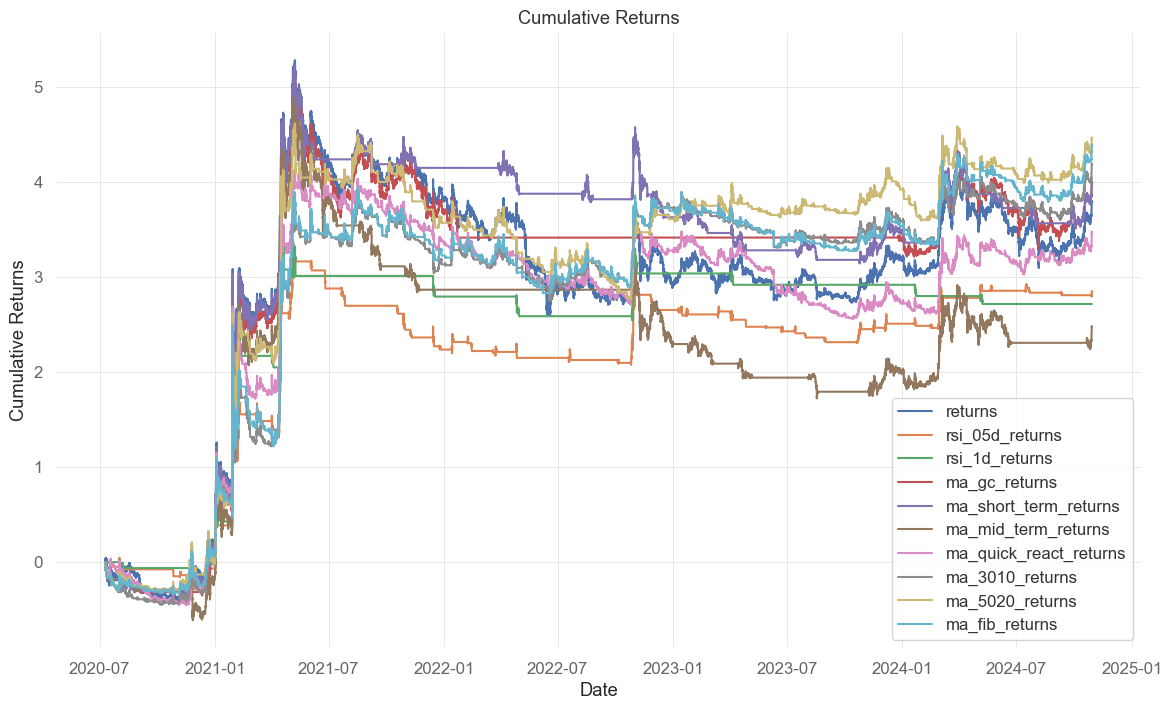

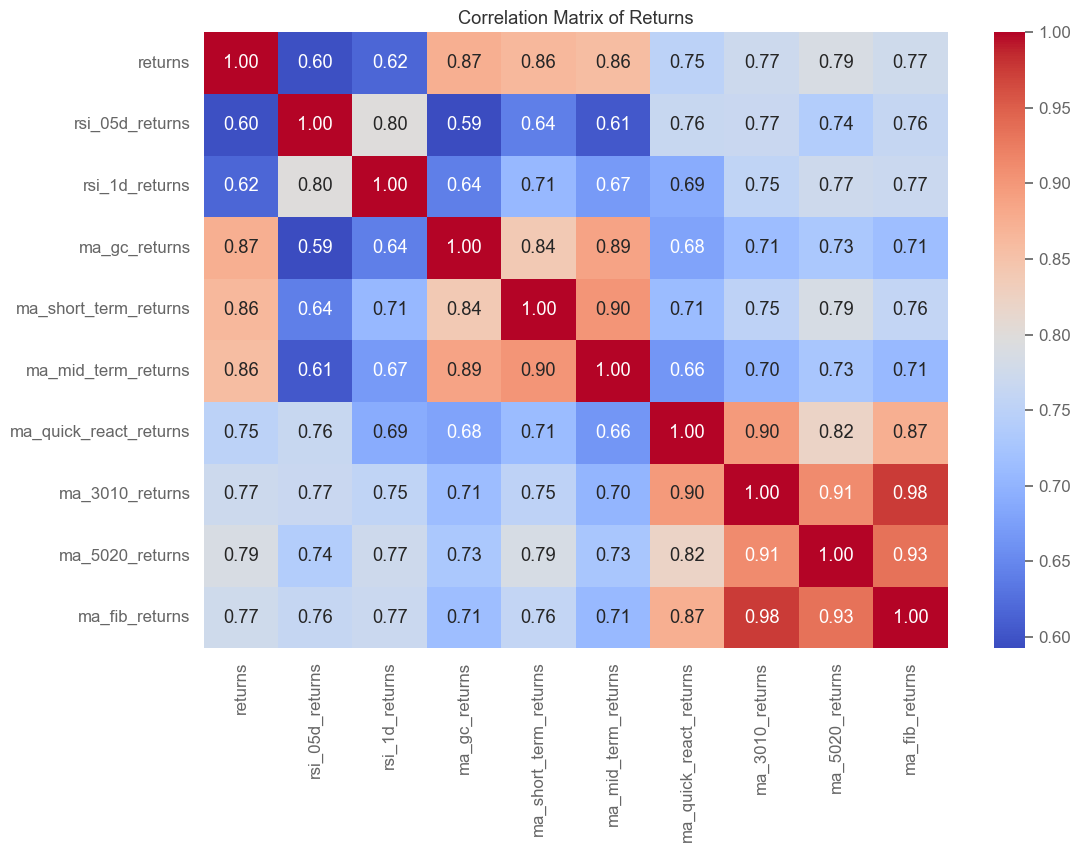

In [30]:
import seaborn as sns

returns_df = signal_df[['returns']].copy()
# returns_df['rsi_2w_returns'] = signal_df['rsi_2w_signal'].shift(1) * signal_df['returns'] # Shift the signal to avoid look-ahead bias
# returns_df['rsi_1w_returns'] = signal_df['rsi_1w_signal'].shift(1) * signal_df['returns']
returns_df['rsi_05d_returns'] = signal_df['rsi_05d_signal'].shift(1) * signal_df['returns']
returns_df['rsi_1d_returns'] = signal_df['rsi_1d_signal'].shift(1) * signal_df['returns']
# returns_df['rsi_4d_returns'] = signal_df['rsi_4d_signal'].shift(1) * signal_df['returns']  
returns_df['ma_gc_returns'] = signal_df['ma_gc_signal'].shift(1) * signal_df['returns']
returns_df['ma_short_term_returns'] = signal_df['ma_short_term_signal'].shift(1) * signal_df['returns']
returns_df['ma_mid_term_returns'] = signal_df['ma_mid_term_signal'].shift(1) * signal_df['returns']
returns_df['ma_quick_react_returns'] = signal_df['ma_quick_react_signal'].shift(1) * signal_df['returns']
returns_df['ma_3010_returns'] = reference_signal_df['ma_3010_signal'].shift(1) * signal_df['returns']
returns_df['ma_5020_returns'] = reference_signal_df['ma_5020_signal'].shift(1) * signal_df['returns']
returns_df['ma_fib_returns'] = reference_signal_df['ma_fib_signal'].shift(1) * signal_df['returns']


# Calculate cumulative sums
cumulative_returns_df = returns_df.cumsum()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for column in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[column], label=column)

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the correlation matrix
correlation_matrix = returns_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Returns')
plt.show()


### Step 11: Comparing Model Predictions with Buy-and-Hold Benchmark

In this final step, we evaluate the effectiveness of the model’s trading signals by comparing the returns generated by its predictions with those of a simple buy-and-hold strategy. By using the `quantstats` package, we can generate a comprehensive performance report.

#### Steps and Calculations
1. **Model Predictions**:
   - We obtain the raw probability predictions from the model (`y_pred_probabilities`) and classify them into binary signals (`y_pred_classes`) using a threshold of 0.5.
   - These predictions indicate whether the model expects the return direction to be positive (1) or neutral/negative (0) for each time step.

2. **Calculating Model-Based Log Returns**:
   - **Log Returns**: We calculate log returns for the asset’s closing prices, which allows us to analyze returns over time.
   - **Position Application**: We multiply the model’s predicted positions by the log returns to generate the **model’s log returns**.
   - **Cumulative Log Returns**: We then compute cumulative log returns for the model, converting them to cumulative returns for easier comparison.

3. **Buy-and-Hold Benchmark**:
   - **Cumulative Buy-and-Hold Returns**: The benchmark strategy assumes holding the asset continuously, so we calculate cumulative returns directly from the log returns without applying any trading signals.

4. **Performance Comparison with `quantstats`**:
   - We use `quantstats` to generate a full report comparing the model’s cumulative returns (`returns_ser`) against the buy-and-hold strategy (`buy_and_hold_ser`).
   - **Purpose**: This report provides an in-depth view of each strategy’s performance, highlighting metrics such as Sharpe ratio, max drawdown, volatility, and cumulative return. It allows us to evaluate whether the model offers an advantage over a simple buy-and-hold approach.

#### Expected Output
- **Performance Metrics**: The `quantstats` report includes various metrics and charts to assess the trading strategy’s risk and return profile.
- **Key Comparison Points**: We aim to see whether the model’s predictions can yield better cumulative returns or risk-adjusted performance relative to the buy-and-hold benchmark, indicating the potential value of a data-driven approach.

This analysis concludes our model’s evaluation, providing a comprehensive comparison to determine if our approach can outperform a passive investment strategy.


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


c:\code\crypto\ml-lecture\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\code\crypto\ml-lecture\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\code\crypto\ml-lecture\venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-12-20   2023-12-20
End Period                 2024-10-29   2024-10-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       42.0%

Cumulative Return          17.09%       54.36%
CAGR﹪                     13.54%       41.84%

Sharpe                     0.12         0.18
Prob. Sharpe Ratio         73.66%       83.52%
Smart Sharpe               0.11         0.18
Sortino                    0.17         0.25
Smart Sortino              0.16         0.25
Sortino/√2                 0.12         0.18
Smart Sortino/√2           0.12         0.17
Omega                      1.06         1.06

Max Drawdown               -69.24%      -42.61%
Longest DD Days            215          234
Volatility (ann.)          16.92%       12.49%
R^2                        0.54         0.54
Information Ratio          0.0          0.0
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-03-10,2024-07-05,2024-10-29,234,-42.611668,-36.725266
2,2024-03-05,2024-03-05,2024-03-09,5,-26.854167,-21.450553
3,2024-01-02,2024-01-03,2024-01-11,9,-12.922510,-12.324710
4,2024-02-29,2024-02-29,2024-03-01,2,-11.612517,-11.084063
5,2024-02-20,2024-02-28,2024-02-28,9,-6.871229,-5.759210


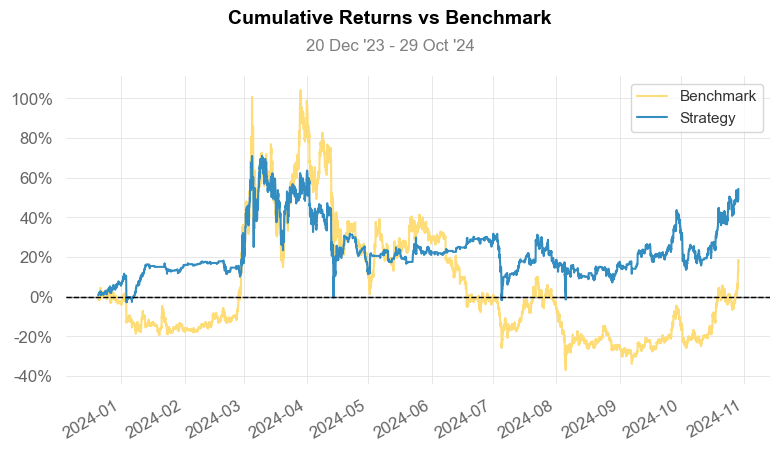

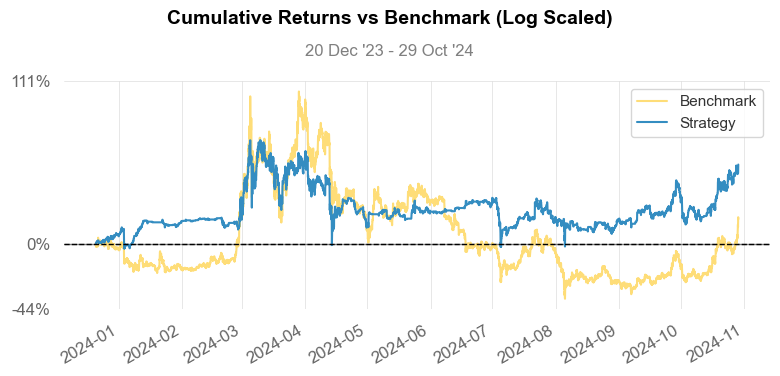

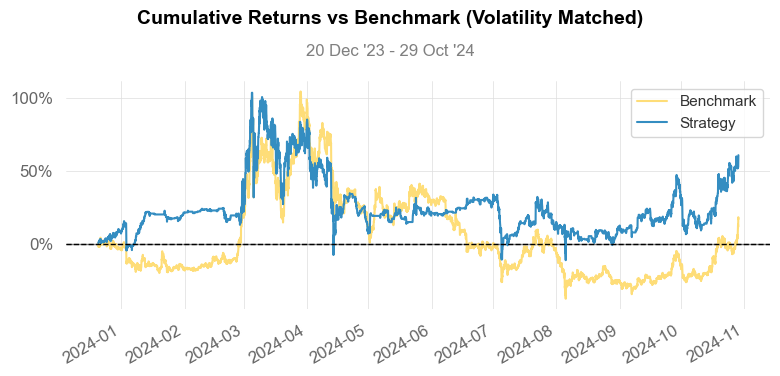

c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


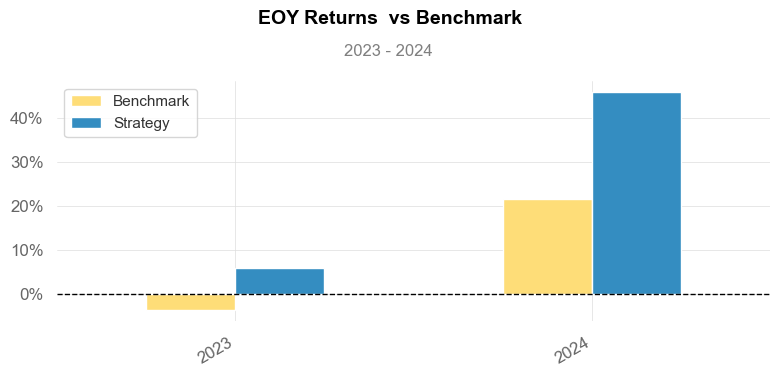

c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\code\crypto\ml-lecture\venv\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


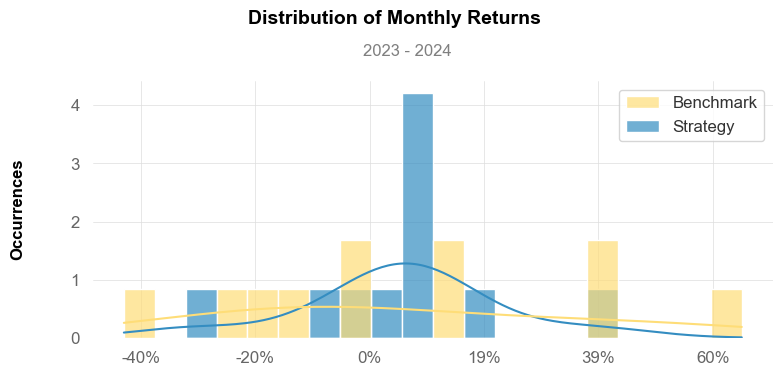

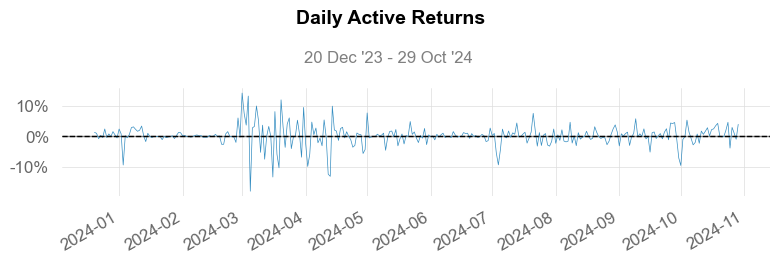

ValueError: Index contains duplicate entries, cannot reshape

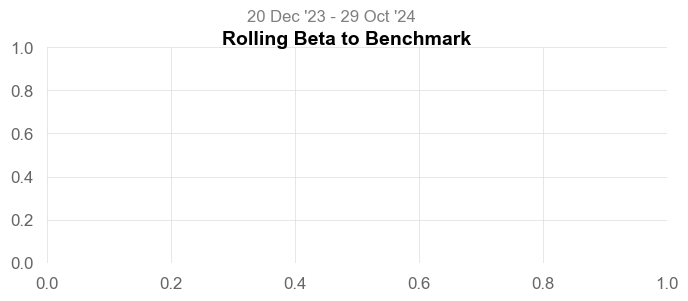

In [29]:
# Get raw predictions
y_pred_probabilities = model.predict(X_test)
y_pred_classes = (y_pred_probabilities > 0.5).astype(int)
y_pred_classes

prices = signal_df['close'].iloc[window_size + split_idx:]

# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).iloc[1:].values  # Skip the first NaN value

# Ensure that the lengths match
positions = y_pred_classes.flatten()
positions = positions[:len(log_returns)]  # Adjust if necessary

# Apply positions to log returns
model_log_returns = positions * log_returns

# Calculate cumulative log returns
cumulative_log_returns = np.cumsum(model_log_returns)

# Convert cumulative log returns to cumulative returns
cumulative_returns = np.exp(cumulative_log_returns)
buy_and_hold_returns = np.exp(np.cumsum(log_returns))

# Extend pandas functionality with quantstats
qs.extend_pandas()

# Assuming 'daily_log_returns' is a pandas Series of daily log returns
returns_ser = pd.Series(model_log_returns, index=prices.index[1:])
buy_and_hold_ser = pd.Series(log_returns, index=prices.index[1:])
quick_react_ma_ser = returns_df['ma_quick_react_returns'].iloc[window_size + split_idx:].copy()

# Remove duplicates in the index for quick_react_returns
quick_react_ma_ser = quick_react_ma_ser[~quick_react_ma_ser.index.duplicated()]

qs.reports.full(returns_ser, buy_and_hold_ser)
